# Score Predictions

In [1]:
import pandas as pd
import numpy as np

from ranked_probability_score import match_outcome

In [2]:
# Get fixture outcomes
outcomes = pd.read_csv("../../data/fivethirtyeight/spi_matches.csv")
outcomes = (
    outcomes
    .loc[(outcomes['league_id'] == 2411) | (outcomes['league_id'] == 2412)]
    .dropna()
    )

# Get GW dates
fixtures = (
    pd.read_csv("../../data/fpl_official/vaastav/data/2021-22/fixtures.csv")
    .loc[:, ['event', 'kickoff_time']])
fixtures["kickoff_time"] = pd.to_datetime(fixtures["kickoff_time"]).dt.date

# Get only EPL games from the current season
season_games = (
    outcomes
    .loc[outcomes['league_id'] == 2411]
    .loc[outcomes['season'] == 2021]
    )
season_games["kickoff_time"] = pd.to_datetime(season_games["date"]).dt.date

# Merge outcomes with GW dates
season_games = (
    pd.merge(
        season_games,
        fixtures,
        left_on='kickoff_time',
        right_on='kickoff_time')
    .drop_duplicates()
    )

## Baselines

In [4]:
from baselines import Baselines

baselines = Baselines(season_games)

# Add the home team and away team index for running inference
idx = (
    pd.DataFrame()
    .assign(team=baselines.teams)
    .assign(team_index=np.arange(baselines.league_size)))
season_games = (
    pd.merge(season_games, idx, left_on="team1", right_on="team")
    .rename(columns={"team_index": "hg"})
    .drop(["team"], axis=1)
    .drop_duplicates()
    .merge(idx, left_on="team2", right_on="team")
    .rename(columns={"team_index": "ag"})
    .drop(["team"], axis=1)
    .sort_values("date")
)

### Uniform Odds

In [5]:
predictions_uniform = baselines.evaluate(season_games, 'uniform')
f"{(np.mean(predictions_uniform.rps)*100):.2f}"

'23.39'

# Comparison

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6

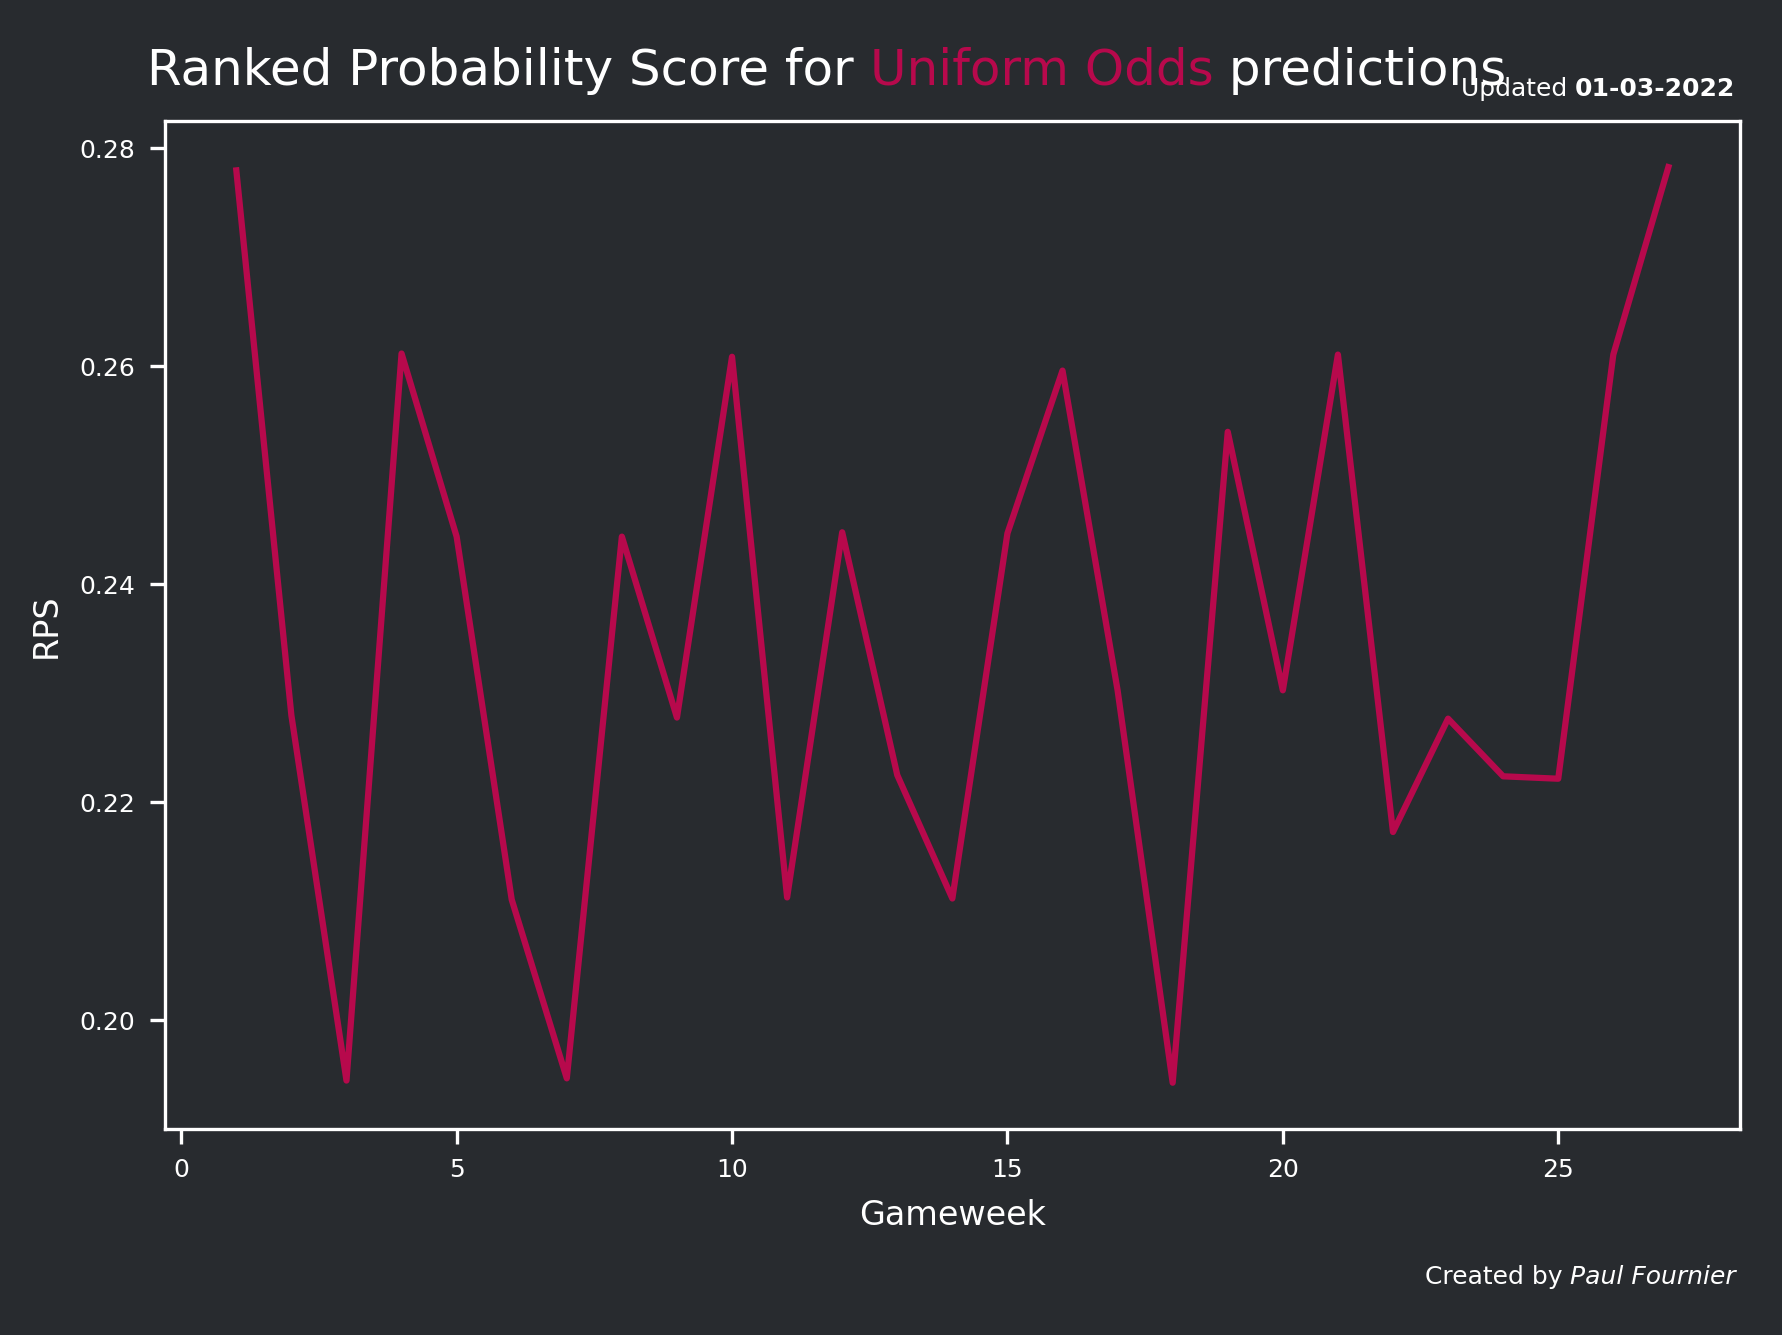

In [7]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(
    predictions_uniform.groupby('event').mean()['rps'],
    color='#b7094c')

ax.set_xlabel('Gameweek', fontsize=8, color=text_color)
ax.set_ylabel('RPS' , fontsize=8, color=text_color)

fig_text(
    x=0.09, y=1.025,
    s="Ranked Probability Score for <Uniform Odds> predictions",
    highlight_textprops=[
        {"color": '#b7094c'},
        ],
    fontsize=12, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.82, y=1.,
    s="Updated <01-03-2022>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=6, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.01,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=6, fontfamily=watermark_font, color=text_color)

plt.show()